<a href="https://colab.research.google.com/github/claudeshyaka/Real-Time_Machine_Learning/blob/main/ConvolutionNeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Claude Shyaka
## ID# 801263243
## Real-Time Machine Learning -- CNNs

In [1]:
!pip install -q d2l==1.0.0-beta0

import torch
from torch import nn
from d2l import torch as d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 55.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.8 MB/s eta 0:00:00


# LetNet Baseline

### LeNet Neural Net from Lecture

In [ ]:
# LeNet model baseline from lecture
class LeNet(d2l.Classifier):
  """The LeNet-5 model"""
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(120), nn.Sigmoid(),
        nn.LazyLinear(84), nn.Sigmoid(),
        nn.LazyLinear(num_classes)
    )

### Additional functions and method to initialize the model and extend the trainer.

In [2]:
# Additional functions and method to initialize the model and 
# extend the trainer.

# define training step to include accuracy measurement.
@d2l.add_to_class(d2l.Classifier)
def training_step(self, batch):
  Y_hat = self(*batch[:-1])
  l = self.loss(Y_hat, batch[-1])
  self.plot('loss', l, train=True)
  self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=True)
  return l

# Model Initializer
def init_cnn(module):
  """Initialize weights for CNNs"""
  if type(module) == nn.Linear or type(module) == nn.Conv2d:
    nn.init.xavier_uniform_(module.weight)

@d2l.add_to_class(d2l.Module)
def apply_init(self, inputs, init=None):
    self.forward(*inputs)
    if init is not None:
        self.net.apply(init)

# Exetend the trainer to train on gpu
@d2l.add_to_class(d2l.Trainer)
def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
    self.save_hyperparameters()
    self.gpus = [d2l.gpu(i) for i in range(min(num_gpus, d2l.num_gpus()))]

# Prepare batch for gpu training.
@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    if self.gpus:
        batch = [a.to(self.gpus[0]) for a in batch]
    return batch

@d2l.add_to_class(d2l.Trainer)
def prepare_model(self, model):
    model.trainer = self
    model.board.xlim = [0, self.max_epochs]
    if self.gpus:
        model.to(self.gpus[0])
    self.model = model

@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

### Training for 10 epochs and 128 batch size with a learning rate of 0.1

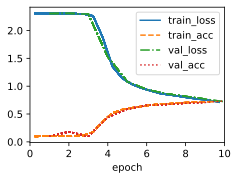

In [ ]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

# Customized LeNet

### Replaced Average Pooling with Max Pooling while keeping Sigmoid as activation function.

In [ ]:
# Custom LeNet Model
# Replaced average pooling with max polling
class CustomLeNet(d2l.Classifier):
  """The LeNet-5 model"""
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(120), nn.Sigmoid(),
        nn.LazyLinear(84), nn.Sigmoid(),
        nn.LazyLinear(num_classes)
    )


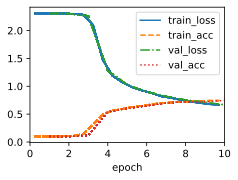

In [ ]:
model = CustomLeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

### Changed the activation function to ReLU while keeping average pooling.

In [ ]:
# Replace the sigmoid activation with ReLU activation.
# with Average Polling.
class CustomReLULeNet(d2l.Classifier):
  """The LeNet-5 model"""
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(120), nn.ReLU(),
        nn.LazyLinear(84), nn.ReLU(),
        nn.LazyLinear(num_classes)
    )

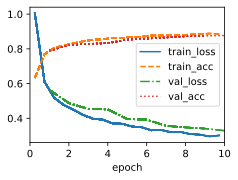

In [ ]:
model = CustomReLULeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

### Changed activation function to ReLU and Pooling to MaxPooling

In [ ]:
# Replace the sigmoid activation with ReLU activation.
# with Max Polling.
class CustomReLUMaxLeNet(d2l.Classifier):
  """The LeNet-5 model"""
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(120), nn.ReLU(),
        nn.LazyLinear(84), nn.ReLU(),
        nn.LazyLinear(num_classes)
    )

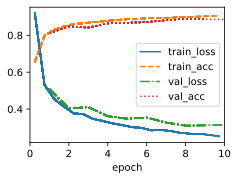

In [ ]:
model = CustomReLUMaxLeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

### Adjusting the convolution window to size of 7

In [3]:
# Replace the sigmoid activation with ReLU activation.
# with Max Polling.
# Addjusting the convolution window size. From size 5 to 7
class CustomReLUMaxLeNet_01(d2l.Classifier):
  """The LeNet-5 model"""
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.LazyConv2d(6, kernel_size=7, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(16, kernel_size=7), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(120), nn.ReLU(),
        nn.LazyLinear(84), nn.ReLU(),
        nn.LazyLinear(num_classes)
    )

# Method to print the layer summary.
@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
  X = torch.randn(*X_shape)
  for layer in self.net:
    X = layer(X)
    print(layer.__class__.__name__, 'output Shape:\t', X.shape)

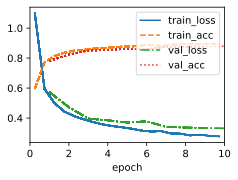

In [ ]:
model_01 = CustomReLUMaxLeNet_01(lr=0.1)
model_01.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model_01, data)

### Adjusting the convolution window size to 3. 
### - Adjusted the number of output channels for first Conv layer to 8 and second Conv layer to 24.


In [ ]:
# Replace the sigmoid activation with ReLU activation.
# with Max Polling.
# Adjusting the convolution window size. From size 5 to 7
# -- Adjusted the number of output channels for first Conv layer to 8
#     and second Conv layer to 24
# -- Adjusted conv kernel sizes to 3 for all conv layers
class CustomReLUMaxLeNet_02(d2l.Classifier):
  """The LeNet-5 model"""
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.LazyConv2d(8, kernel_size=3, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(24, kernel_size=3), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(120), nn.ReLU(),
        nn.LazyLinear(84), nn.ReLU(),
        nn.LazyLinear(num_classes)
    )

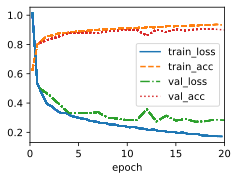

In [ ]:
model_02 = CustomReLUMaxLeNet_02(lr=0.1)
model_02.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer_lr_01 = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer_lr_01.fit(model_02, data)

### Added a convolution layer with 40 output channels and a kernel size of 3, then an activation function of ReLU. Also added a max pooling with kernel size of 2 and stride of 2.

In [ ]:
# Replace the sigmoid activation with ReLU activation.
# with Max Polling.
# Adjusting the convolution window size. From size 5 to 7
# -- Adjusted the number of output channels for first Conv layer to 8
#     and second Conv layer to 24
# -- Adjusted conv kernel sizes to 3 for all conv layers
# -- Adding a Conv layer with output channels of 40 and kernel size of 3
# -- Adding a MaxPool layer with kernel size of 2 and stride of 2
class CustomReLUMaxLeNet_03(d2l.Classifier):
  """The LeNet-5 model"""
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.LazyConv2d(8, kernel_size=3, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(24, kernel_size=3), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(40, kernel_size=3), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(120), nn.ReLU(),
        nn.LazyLinear(84), nn.ReLU(),
        nn.LazyLinear(num_classes)
    )

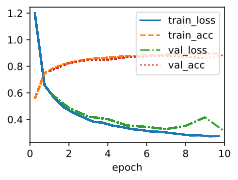

In [ ]:
model_03 = None
model_03 = CustomReLUMaxLeNet_03(lr=0.1)
model_03.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model_03, data)

### Adding a fully connected layer output 254.

In [4]:
# Replace the sigmoid activation with ReLU activation.
# with Max Polling.
# Adjusting the convolution window size. From size 5 to 7
# -- Adjusted the number of output channels for first Conv layer to 8
#     and second Conv layer to 24
# -- Adjusted conv kernel sizes to 3 for all conv layers
# -- Adding a Conv layer with output channels of 36 and kernel size of 4
# -- Adding a MaxPool layer with kernel size of 4 and stride of 2
# -- Adding a fully connected layer with 254 output features
class CustomReLUMaxLeNet_04(d2l.Classifier):
  """The LeNet-5 model"""
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.LazyConv2d(8, kernel_size=3, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(24, kernel_size=3), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(40, kernel_size=3), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(254), nn.ReLU(),
        nn.LazyLinear(120), nn.ReLU(),
        nn.LazyLinear(84), nn.ReLU(),
        nn.LazyLinear(num_classes)
    )

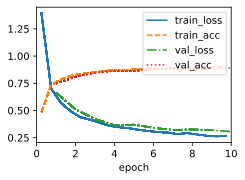

In [ ]:
model_04 = None
model_04 = CustomReLUMaxLeNet_04(lr=0.1)
model_04.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model_04, data)

### Explored different learning rate and found that lr of 0.1 performed better

In [ ]:
# Replace the sigmoid activation with ReLU activation.
# with Max Polling.
# Adjusting the convolution window size. From size 5 to 7
# -- Adjusted the number of output channels for first Conv layer to 8
#     and second Conv layer to 24
# -- Adjusted conv kernel sizes to 3 for all conv layers
# -- Adding a Conv layer with output channels of 36 and kernel size of 4
# -- Adding a MaxPool layer with kernel size of 4 and stride of 2
# -- Adding a fully connected layer with 254 output features
# -- Exploring different learning rates
class CustomReLUMaxLeNet_05(d2l.Classifier):
  """The LeNet-5 model"""
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.LazyConv2d(8, kernel_size=3, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(24, kernel_size=3), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(40, kernel_size=3), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(254), nn.ReLU(),
        nn.LazyLinear(120), nn.ReLU(),
        nn.LazyLinear(84), nn.ReLU(),
        nn.LazyLinear(num_classes)
    )

In [ ]:
import numpy as np
lr_c = np.logspace(-5, -1, 5)
lr_c

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])

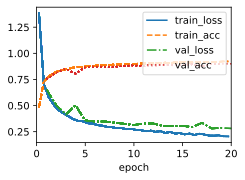

In [ ]:
model_05 = None
model_05 = CustomReLUMaxLeNet_05(lr=1e-01)
model_05.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer_lr = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer_lr.fit(model_05, data)

### Measured one of model's complexity with ptflops. See below for results

In [ ]:
!pip install -q ptflops

  Preparing metadata (setup.py) ... done


In [ ]:
# Measuring model complexity
from ptflops import get_model_complexity_info

with torch.cuda.device(0):
  net = model_04
  macs, params = get_model_complexity_info(net, (1, 28, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

CustomReLUMaxLeNet_04(
  93.02 k, 100.000% Params, 613.73 KMac, 100.000% MACs, 
  (net): Sequential(
    93.02 k, 100.000% Params, 613.73 KMac, 100.000% MACs, 
    (0): Conv2d(80, 0.086% Params, 72.0 KMac, 11.732% MACs, 1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU(0, 0.000% Params, 7.2 KMac, 1.173% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 7.2 KMac, 1.173% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(1.75 k, 1.883% Params, 296.09 KMac, 48.244% MACs, 8, 24, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(0, 0.000% Params, 4.06 KMac, 0.661% MACs, )
    (5): MaxPool2d(0, 0.000% Params, 4.06 KMac, 0.661% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(8.68 k, 9.331% Params, 138.88 KMac, 22.629% MACs, 24, 40, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(0, 0.000% Params, 640.0 Mac, 0.104% MACs, )
    (8): MaxPool2d(0, 0.000% Params, 640.0 Mac, 0.104% MACs, kernel_size=2, stride

# Customized LeNet and Dropout added for generalization


In [ ]:
# Replace the sigmoid activation with ReLU activation.
# with Max Polling.
# Adjusting the convolution window size. From size 5 to 7
# -- Adjusted the number of output channels for first Conv layer to 8
#     and second Conv layer to 24
# -- Adjusted conv kernel sizes to 3 for all conv layers
#
class CustomReLUMaxLeNet_02Drp(d2l.Classifier):
  """The LeNet-5 model"""
  def __init__(self, lr=0.1, num_classes=10, dropout_1=0.3, dropout_2=0.3):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.LazyConv2d(8, kernel_size=3, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(24, kernel_size=3), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(120), nn.ReLU(), nn.Dropout(dropout_1),
        nn.LazyLinear(84), nn.ReLU(), nn.Dropout(dropout_2),
        nn.LazyLinear(num_classes)
    )

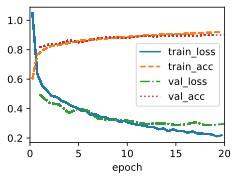

In [ ]:
model_02Drp = CustomReLUMaxLeNet_02Drp(lr=0.1)
model_02Drp.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer_lr_Drp = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer_lr_Drp.fit(model_02Drp, data)

In [5]:
# Replace the sigmoid activation with ReLU activation.
# with Max Polling.
# Adjusting the convolution window size. From size 5 to 7
# -- Adjusted the number of output channels for first Conv layer to 8
#     and second Conv layer to 24
# -- Adjusted conv kernel sizes to 3 for all conv layers
# -- Adding a Conv layer with output channels of 36 and kernel size of 4
# -- Adding a MaxPool layer with kernel size of 4 and stride of 2
# -- Adding a fully connected layer with 254 output features
# -- Exploring different learning rates
class CustomReLUMaxLeNet_04Drp(d2l.Classifier):
  """The LeNet-5 model"""
  def __init__(self, lr=0.1, num_classes=10, dropout_1=0.3, dropout_2=0.3):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.LazyConv2d(8, kernel_size=3, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(24, kernel_size=3), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(40, kernel_size=3), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(254), nn.ReLU(), nn.Dropout(dropout_1),
        nn.LazyLinear(120), nn.ReLU(), nn.Dropout(dropout_2),
        nn.LazyLinear(84), nn.ReLU(),
        nn.LazyLinear(num_classes)
    )

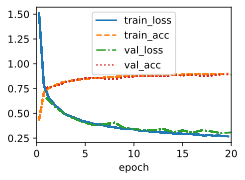

In [7]:
model_04Drp = None
model_04Drp = CustomReLUMaxLeNet_04Drp(lr=1e-01)
data = d2l.FashionMNIST(batch_size=128)
model_04Drp.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer_lr04 = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer_lr04.fit(model_04Drp, data)

# AlexNet

In [ ]:
# AlexNet Moddified for the FashionMNIST Dataset
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)


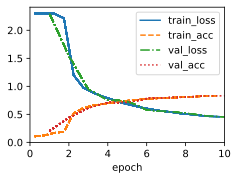

In [ ]:
trainerAlexNet = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
modelAlexNet = AlexNet(lr=0.01)
# modelAlexNet.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainerAlexNet.fit(modelAlexNet, data)

In [8]:
# AlexNet Moddified for the FashionMNIST Dataset
# -- Reduce the dropout to 0.3
# -- change kernel size of first layer to 7 and stride to 2
class CustomAlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.3),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.3),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

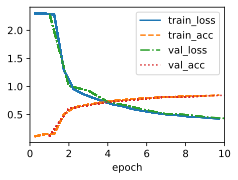

In [9]:
trainerCustomAlexNet = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
modelCustomAlexNet = CustomAlexNet(lr=0.01)
trainerCustomAlexNet.fit(modelCustomAlexNet, data)